In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

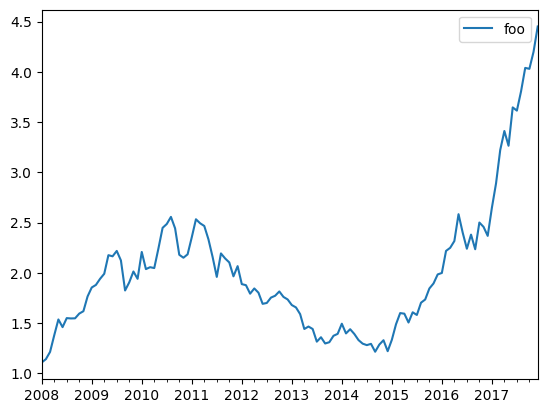

In [2]:
np.random.seed(0)
returns =  np.random.normal(0.08/12,0.2/np.sqrt(12),12*10)
pdf = pd.DataFrame(
    np.cumprod(1+returns),
    index = pd.date_range(start="2008-01-01",periods=12*10,freq="m"),
    columns=['foo']
)

pdf.plot()

In [3]:
runMonthlyAlgo = bt.algos.RunMonthly()
rebalAlgo = bt.algos.Rebalance()

class Signal(bt.Algo):

    """

    Mostly copied from StatTotalReturn

    Sets temp['Signal'] with total returns over a given period.

    Sets the 'Signal' based on the total return of each
    over a given lookback period.

    Args:
        * lookback (DateOffset): lookback period.
        * lag (DateOffset): Lag interval. Total return is calculated in
            the inteval [now - lookback - lag, now - lag]

    Sets:
        * stat

    Requires:
        * selected

    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 lag=pd.DateOffset(days=0)):
        super(Signal, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
        selected = 'foo'
        t0 = target.now - self.lag

        if target.universe[selected].index[0] > t0:
            return False
        prc = target.universe[selected].loc[t0 - self.lookback:t0]


        trend = prc.iloc[-1]/prc.iloc[0] - 1
        signal = trend > 0.

        if signal:
            target.temp['Signal'] = 1.
        else:
            target.temp['Signal'] = 0.

        return True

signalAlgo = Signal(pd.DateOffset(months=12),pd.DateOffset(months=1))

class WeighFromSignal(bt.Algo):

    """
    Sets temp['weights'] from the signal.
    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        super(WeighFromSignal, self).__init__()

    def __call__(self, target):
        selected = 'foo'
        if target.temp['Signal'] is None:
            raise(Exception('No Signal!'))

        target.temp['weights'] = {selected : target.temp['Signal']}
        return True

weighFromSignalAlgo = WeighFromSignal()

In [4]:
s = bt.Strategy(
    'example1',
    [
        runMonthlyAlgo,
        signalAlgo,
        weighFromSignalAlgo,
        rebalAlgo
    ]
)

t = bt.Backtest(s, pdf, integer_positions=False, progress_bar=True)
res = bt.run(t)

example1
0% [############################# ] 100% | ETA: 00:00:00

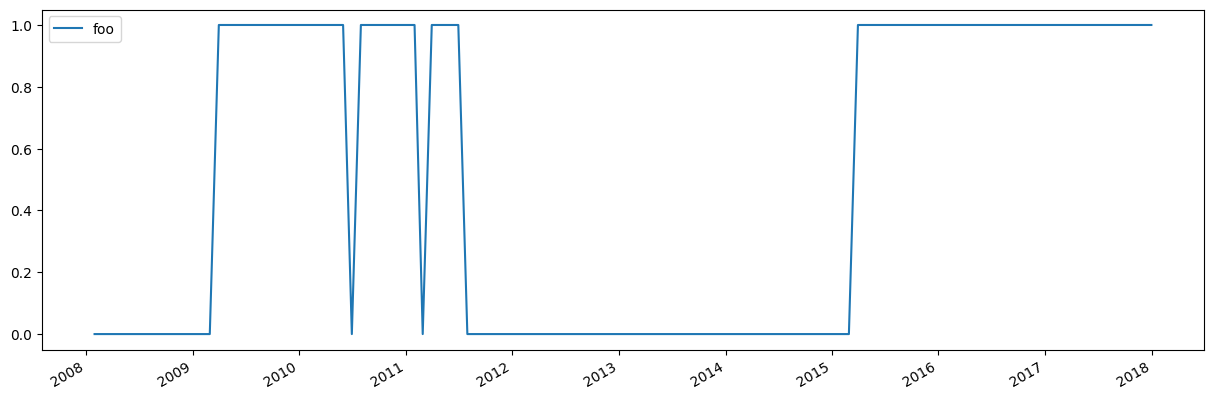

In [5]:
res.plot_security_weights();

In [6]:
t.positions

,foo
2008-01-30,0.000000
2008-01-31,0.000000
2008-02-29,0.000000
2008-03-31,0.000000
2008-04-30,0.000000
...,...
2017-08-31,631321.251898
2017-09-30,631321.251898
2017-10-31,631321.251898
2017-11-30,631321.251898


In [7]:
res.prices.tail()

,example1
2017-08-31,240.302579
2017-09-30,255.046653
2017-10-31,254.464421
2017-11-30,265.182603
2017-12-31,281.069771


In [8]:
res.stats

,example1
start,2008-01-30 00:00:00
end,2017-12-31 00:00:00
rf,0.0
total_return,1.810698
cagr,0.109805
max_drawdown,-0.267046
calmar,0.411186
mtd,0.05991
three_month,0.102033
six_month,0.22079
